In [1]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import time
rand_state = 42
tf.set_random_seed(rand_state)
np.random.seed(rand_state)

import warnings
warnings.simplefilter('ignore')

# Outline  

1. Introduction
2. Data
  * Feature Engineering
3. Visualization
  * Kernel PCA
  * t-SNE
4. Classification
  * SVM
  * Classification metrics
5. Regression
  * XGBoost
  * Deep Learning
    * MLP
    * CNN
6. Conclusions



# Introduction  

Research and development (R&D) costs for US based pharmaceutical companies have risen 43.9% just over the last 5 years ([source](https://www.statista.com/statistics/265085/research-and-development-expenditure-us-pharmaceutical-industry/)). R&D spending has increased by 27% since 2010 and is projected to increase by another 23.6% over the next 5 years; R&D accounts for roughly 21% of all pharmaceutical sales, this pipeline can be summarized as so:  

  1. Pre-clinical  
  2. Phase 1 clinical trials  
  3. Phase II  
  4. Phase III  
  5. Pre-registration  
  6. Registered  
  7. Launched  
  8. Suspended  
  
The most resources (by far) are spent in the pre-clinical stage ([source](https://www.statista.com/statistics/791288/r-and-d-pipeline-drugs-worldwide-by-phase-development/)), with drug discovery being one of the initial steps in this process. Drug discovery is the process by which new candidate medications are discovered. In classical pharmacology, chemical libraries of synthetic small molecules, natural products or extracts are utilized in combination with in-vitro studies to identify substances that have a desirable therapeutic effect. 

Since the sequencing of the human genome, it has become common practice to use high throughput screening of large compounds libraries against isolated biological targets which are hypothesized to be disease modifying in a process known as reverse pharmacology. The candidate drugs are then tested for efficacy in-vivo. Various chemical properties, such as ADME (absorption, distribution, metabolism and excretion) as well as atomization energy have been shown to play a crucial role in the screening of such compounds, and that is where machine learning can help! The accurate prediction of molecular energetics in chemical compound space is a crucial ingredient for rational compound design.  

Currently only high-level quantum-chemistry calculations, which can take days per molecule depending on property and system, yield the desired “chemical
accuracy” of 1 kcal/mol required for computational molecular design. Here, I am proposing a less expensive machine learning approach to predicting this the quantum mechanical property of atomization energy. To accomplish this objective, I will engineer features to work well with a gradient boosting regression model, support vector machine classification model, as well as a multilayer perceptron network and a convolutional neural network. 

# Data  

I am using the QM7 dataset, which is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) containing up to 7 heavy atoms C, N, O, and S. The 3D Cartesian coordinates of the most stable conformations and their atomization energies were determined using ab-initio density functional theory (PBE0/tier2 basis set). This dataset also provided Coulomb matrices as calculated in [Rupp et al. PRL, 2012]:  
  * $C_{i,i} = 0.5 \cdot Z^2.4$  
  * $C_{i,j} = Z_i \cdot \frac{Z_j}{|(R_i−R_j)|}$ 
  * $Z_i$ - nuclear charge of atom i  
  * $R_i$ - cartesian coordinates of atom i  

The data file (.mat format, we recommend using `scipy.io.loadmat` for python users) contains five arrays:  
  * "X" - (7165 x 23 x 23), Coulomb matrices  
  * "T" - (7165), atomization energies (unit: kcal/mol)  
  * "P" - (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]  
  * "Z" - (7165 x 23), atomic charges  
  * "R" - (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules   


## Feature Engineering  

The data is stored in a MATLAB file, so we read that using SciPy. For the regression models, I take the upper triangle of each Coulomb Matrix (with diagonal) and unroll it so each has the shape: (1, num_atoms*(num_atoms+1)/2). I then compute the pairwise distance matrix and from this get the corresponding Eigenvalues and [Eigenvector Centralities](https://en.wikipedia.org/wiki/Eigenvector_centrality). I am attempting to estimate the influence one particular atom plays on the entire molecule; typically, this is performed on an adjacency matrix (graph), however, I am assuming the connectivity (bonds) are not known upfront (can be accurately predicted via Monte Carlo simulations).  

## Previous work  
This is an extension to some earlier research that I previously [conducted](https://www.kaggle.com/mjmurphy28/predicting-ground-state-energy). That study (and therefore this one also) is primarily based off two previous studies: a 2016 publication by [B. Himmetoglu](https://arxiv.org/abs/1609.07124) and a team of researchers at [Stanford](http://moleculenet.ai). The earlier work by Himmetoglu reported a RMSE of 38.75 kcal/mol on the train set and 36.83 on the test set. I was not able to find the full results from the team at Stanford, however, on their [site](http://moleculenet.ai/latest-results) they list a MAE of 8.56 (I am assuming that this metric comes from evaluating their TensorFlow regression model on the test set).

In [2]:
qm7 = scipy.io.loadmat('./data/qm7/qm7.mat')
X_cm = qm7['X']
# compute the Eigenvectors of the pairwise distance matrix?
R = qm7['R']
Z = qm7['Z']
y = np.transpose(qm7['T']).reshape((7165,))


num_atoms = X_cm.shape[1]
X_eigs = np.zeros((X_cm.shape[0], num_atoms, num_atoms), dtype=float)

for i, cm in enumerate(X_cm):
    w, v = np.linalg.eig(cm)
    X_eigs[i] = v


y_scaling_factor = 2000.
y_scaled = y / y_scaling_factor

I also computed the number of atoms per molecule, primarily for visualization purposes. This data presents an interesting problem, as the number of atoms per molecule is not fixed. 

In [3]:
k=0 # 0 = include diagnol, 1 = do not include diagnol

iu = np.triu_indices(num_atoms,k=k) 
iu_dist = np.triu_indices(num_atoms,k=1) # for the pairwise distance matrix, all diagonol entries will be 0 



data_atoms = np.zeros((X_cm.shape[0], 1), dtype=int)
data_CM = np.zeros((X_cm.shape[0], num_atoms*(num_atoms+1)//2), dtype=float)
data_eigs = np.zeros((X_cm.shape[0], num_atoms), dtype=float)
data_centralities = np.zeros((X_cm.shape[0], num_atoms), dtype=float)
data_pdist = np.zeros((X_cm.shape[0], ((num_atoms*num_atoms)-num_atoms)//2), dtype=float) 

for i, cm in enumerate(X_cm):
    coulomb_vector = cm[iu]
    # Sort elements by decreasing order
    shuffle = np.argsort(-coulomb_vector)
    data_CM[i] = coulomb_vector[shuffle]
    data_atoms[i] = np.count_nonzero(R[i], axis=0)[0]
    dist = squareform(pdist(R[i]))
    # we can extract the upper triangle of the distance matri: return vector of dimension (1,num_atoms)
    dist_vector = dist[iu_dist]
    shuffle = np.argsort(-dist_vector)
    data_pdist[i] = dist_vector[shuffle]
    
    w,v = np.linalg.eig((dist))
    data_eigs[i] = w[np.argsort(-w)]
    data_centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))
    
X = np.concatenate((data_CM, data_eigs, data_centralities, data_pdist, data_atoms), axis=1)
X.shape

(7165, 576)

**Molecular Graph**  

Let's see if we can make a graph from simply the 3 dimensional coordinates (remember we are acting as if we do not know the bonds). We can then use this graph to compute various properties such as the connectivity of nodes (atoms).  

I am going to use [van der Waal radii](https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page))

In [89]:
# these radii measurements are in picometers: 10^-12 m

radii = {
    1: 120e-12,
    6: 170e-12,
    7: 155e-12,
    8: 152e-12,
    9: 147e-12, 
    14: 210e-12,
    15: 180e-12,
    16: 180e-12,
    17: 175e-12
}

valence_elctrons = {
    1: 1,
    6: 4,
    7: 5,
    8: 6,
    9: 7,
    14: 4,
    15: 5,
    16: 6,
    17: 7 
}

In [35]:
'''
    Create Node
    -----------
    1. Create position vector
    2. 

'''
def pos_for_molecule(molecule_coords):
    # how many nodes in this molecule?
    num_nodes = np.count_nonzero(molecule_coords, axis=1)[0]+1
    pos = {}
    #pos = {i: (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)) for i in range(n_nodes)}
    for i, coords in enumerate(molecule_coords):
        if i > num_nodes:
            break
        pos[i] = (coords[0], coords[1], coords[2])
    return num_nodes, pos

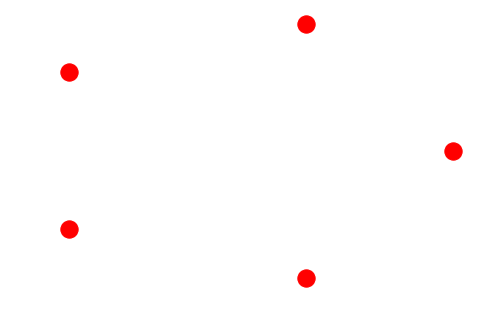

In [134]:
mol_idx = 0

num_nodes, positions = pos_for_molecule(R[mol_idx])

G = nx.Graph()
pos = dict()
for i, couple in enumerate(positions):
        G.add_node(i)
        pos[i] = couple


# now make up radius for each node
# this should be the Bohr Radius corresponding to the type of atom (hydrogen)
for i, node in enumerate(G.nodes()):
    G.node[node]['rad'] = radii.get(Z[mol_idx][i], 0.0)

nx.draw_circular(G)

In [155]:
'''
    Create most likely bond. To compute this we need to:
        1. Compute pairwise distance between all nodes
        2. 
'''


'''
    need to adjust this matrix to account for the radius of each atom
    going to add the van der Waal radius to the node in question
    and going to subtract the radius from all other nodes in the network
''' 

def get_bonds(mol_idx):
    dm = squareform(data_pdist[mol_idx])[:num_nodes, :num_nodes]
    dm2 = dm.copy()

    for i, j in zip(range(dm.shape[0]), range(dm.shape[1])):
        if i == j:
            continue
        r1 = radii.get(Z[0][i])
        r2 = radii.get(Z[0][j])
        # now update
        dm2[i,j] = dm[i,j] - r1 - r2

    bonds = np.zeros((dm2.shape))

    for i, j in zip(range(dm2.shape[0]), range(dm2.shape[1])):
        # these are the possible nodes node i can bind to
        binding = np.delete(np.argsort(dm2[i,:]), [i])[:valence_elctrons.get(Z[0][i])]
        # create an edge for all of the above (just set to 1)
        # and set i,j to 0
        bonds[i, (i+1):] = binding>0

    return bonds

In [157]:
bonds = get_bonds(0)

**TODO**  

Do I need to **_reshape_** these adjacency matrices? 

For example, a molecule that only contains 5 atoms (so max of 4 bonds) will be a 5 by 5 adjacency matrix, padded with zeros to all adj. matrices are of the shape (23, 23).

**Normalization**  

Because the values of the Coulomb Matrices can vary so widely (0 to 388.02344) we will need to scale/normalize these values for input to any deep learning model.

In [ ]:
from sklearn.preprocessing import normalize

CM_norm = X_cm.copy()

for i,cm in enumerate(X_cm):
    CM_norm[i] = normalize(cm, axis=1, norm='l1')
    
CM_norm = CM_norm.reshape((7165, 23, 23, 1))

X_eigs = X_eigs.reshape((7165, 23, 23, 1))

# Visualization

In [ ]:
def mean_dist(x):
    x[x == 0] = np.nan
    return np.nanmean(x, axis=0)



mean_dists = np.apply_along_axis(mean_dist, axis=1, arr=data_pdist)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Histogram of number of atoms')
plt.hist(data_atoms, bins=20)
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data_atoms.reshape(-1,), y)
plt.xlabel('Number of atoms')
plt.ylabel('E (kcal/mol)')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(mean_dists)
plt.xlabel('Interatomic Distance')
plt.ylabel('Probability')
plt.title('Distribution of interatomic distances')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(y)
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of Atomization Energy')
plt.show()

Let us try to visualize just the **Coulomb Matrices**.

In [ ]:
from sklearn.decomposition import KernelPCA
from matplotlib import cm

start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="rbf")
CM_reduced = kpca.fit_transform(data_CM)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(CM_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(CM_reduced[:,0], CM_reduced[:,1], c=y, s=60, edgecolors='black', cmap=cm.jet_r)
colorbar = fig.colorbar(scatter, ax=ax, label = "(kcal/mol)")
plt.xlabel(r'$k-PCA_1$')
plt.ylabel(r'$k-PCA_1$')
plt.title("Visualizing Coulomb Matrix: RBF Kernel")
sns.despine()
plt.show()

Now add all features (576).

In [ ]:
start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="cosine")
X_reduced = kpca.fit_transform(X)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(X_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y, s=60, edgecolors='black', cmap=cm.jet_r)
colorbar = fig.colorbar(scatter, ax=ax, label = "E (kcal/mol)")
plt.xlabel(r'$k-PCA_1$')
plt.ylabel(r'$k-PCA_1$')
plt.title("Visualizing All Features: Cosine Kernel")
plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
# Split into (roughly) equal groups
              
def get_category(x):
    ''' > -1700, (-1700, -1540), (-1540, -1370), > -1370 '''
    if x < -1700:
        return 0
    elif -1700 <= x < -1540:
        return 1
    elif -1540 <= x < -1370:
        return 2
    elif x > -1370:
        return 3

y_class = pd.Series(y).apply(get_category).values

# Classification  

First I will create a model to classify a given atom into one of four classes, based on atomization energy. I have manually constructed my classes so that they are roughly balanced. A tool like this can provide us insight into 'tricky' molecules, those that are difficult to distinguish among.  

I will split my data into **70/20/10** train/dev/val sets.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_2, X_val, y_class_2, y_class_val = train_test_split(X, y_class.astype(int), 
                                                    test_size=0.15, 
                                                    random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_class_train, y_class_dev = train_test_split(X_2, y_class_2, 
                                                    test_size=0.18, 
                                                    random_state=rand_state)

clf = SVC(kernel='linear', random_state=rand_state)
clf.fit(X_train, y_class_train)
print("Train score: ", clf.score(X_train, y_class_train))
print("Test score: ", clf.score(X_dev, y_class_dev))

print('--------\nEVALUATE on validation set\n--------')
class_preds = clf.predict(X_val)
print(classification_report(y_class_val, class_preds))

In [ ]:
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(SVC(kernel='linear', random_state=rand_state), classes=[0,1,2,3], support=True)

visualizer.fit(X_train, y_class_train)  # Fit the visualizer and the model
visualizer.score(X_val, y_class_val)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(kernel='linear', random_state=rand_state), classes=[0,1,2,3]
)

# X_train, X_test, y_class_train, y_class_test
# Fit the training data to the visualizer
visualizer.fit(X_train, y_class_train)

# Evaluate the model on the test data
visualizer.score(X_val, y_class_val)

# Draw visualization
g = visualizer.poof()

In [ ]:
from yellowbrick.classifier import ROCAUC

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(SVC(kernel='linear', random_state=rand_state), classes=[0,1,2,3])

visualizer.fit(X_train, y_class_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_class_val)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(SVC(kernel='linear', random_state=rand_state), classes=[0,1,2,3])
viz.fit(X_train, y_class_train)
viz.score(X_val, y_class_val)
viz.poof()

**Conclusons**  

I was able to build a pretty good classification model; one that predicts the most likely bin or range of atomization energies that molecule belongs to. Our intervals were as follows:
  1. y < -1700
  2. -1700 <= y < -1540
  3. -1540 <= y < -1370
  4. y > -1370

We see high AUC values for all classes, except for class 2. This might indicate that detecting patterns with explanatory power is more difficult for molecules belonging to that class. In other words, we would expect to be more confident in predicting atomization energies less than -1700 kcal/mol over those exhibiting energies above -1540. While the interatomic distances offered some explanatory power for classification purposes, they aactually cause the regression model to be less accurate so we will drop these features for the regression portion of this project. 

# Regression

First, I am going to split my data into 70/15/15 train/dev/validation sets, and use 3-fold cross validation when training my model. Through experimentation (as well as previous [work](https://www.kaggle.com/mjmurphy28/predicting-ground-state-energy)) XGBoost provides excellent accuracy, while very low training time. I settled on the following hyper-parameters through intuition, literature as well as trial and error. As mentioned above, a number of the features that I engineered  solely for classification purposes do not add any explanatory power to my regression model, therefore I will only be using the unrolled Coulomb Matrix, Eigenvector centralities and Eigenvalues (of the interatomic distance matrix). 

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = np.concatenate((data_CM, data_eigs, data_centralities), axis=1)


# with cross validation no need to further split the data. if not using cross validation you should do one...
X_2, X_val, y_2, y_val = train_test_split(X, y, 
                                          test_size=0.15, 
                                          random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)


n_folds = 5
early_stopping = 50


start_time = time.time()
xg_train = xgb.DMatrix(X_train, label=y_train)

params = {"objective":"reg:linear", 
          'booster': 'gbtree', 
          'eval_metric': 'mae',
          'subsample': 0.9,
          'colsample_bytree':0.2,
          'learning_rate': 0.06,
          'max_depth': 5, 
          'reg_lambda': .9, 
          'reg_alpha': .01,
          'seed': rand_state}


cv = xgb.cv(params,
            xg_train, 
            num_boost_round=200, 
            nfold=n_folds, 
            early_stopping_rounds=early_stopping, 
            verbose_eval = 0, 
            seed=rand_state,
            as_pandas=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(8,8))
plt.plot(cv['train-mae-mean'][100:], label='Train loss: ' + str(np.min(cv['train-mae-mean'])))
plt.plot(cv['test-mae-mean'][100:], label='Test loss: ' + str(np.min(cv['test-mae-mean'])))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.show()

By adding regularization I was able to decrease the amount our model overfits to the train data. Note that if you run this model for more boosting rounds (iterations) the model begins to significantly overfit. Setting the max depth of each tree also helps reduce this.

In [ ]:
model_xgb = xgb.XGBRegressor(**params, random_state=rand_state, n_estimators=200)
model_xgb.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping, 
              eval_metric='mae', 
              eval_set=[(X_dev, y_dev)], 
              verbose=False)

y_dev_pred = model_xgb.predict(X_dev)
print('Dev mean absoulte error: ', mean_absolute_error(y_dev, y_dev_pred))

y_val_pred = model_xgb.predict(X_val)
print('Validation mean absoulte error: ', mean_absolute_error(y_val, y_val_pred))

In [ ]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(xgb.XGBRegressor(**params, n_estimators=200, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()       

Notice the shape of the distributions, notably those belonging to class 2.

In [ ]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(xgb.XGBRegressor(**params, n_estimators=200, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Neural Networks 

## Feedforward  

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [ ]:
CM_unrolled = CM_norm.reshape((7165, 529))
X_cm_train, X_cm_test, y_train, y_test  = train_test_split(CM_unrolled, y_scaled, test_size=.2, random_state=rand_state)


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_cm_train.shape[1], activation='relu'))

# The Hidden Layers :
#NN_model.add(Dropout(.2))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dropout(.2))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dropout(.2))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', 
                 optimizer=optimizers.Adam(lr=.0001), 
                 metrics=['mean_absolute_error'])
NN_model.summary()



checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

NN_model.fit(X_cm_train, y_train, 
             validation_data=(X_cm_test, y_test), 
             verbose=0,
             epochs=50, 
             batch_size=8, 
             callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

print('Train loss: ', 2000*mean_absolute_error(y_train, NN_model.predict(X_cm_train)))
print('Test loss: ', 2000*mean_absolute_error(y_test, NN_model.predict(X_cm_test)))

## Convolutional Neural Network 

Translational invariance is a critical aspect to why convnet's are so effective when dealing with images, and here I am envisioning the Coulomb Matrix similar to a single-channel image (matrix of pixels), and I suspect that the Coulomb Matrix exhibits some form of translational invariance. 

In [ ]:
'''
convnets require specific input dimensions, in this case every example should be a (23, 23, 1) Coulom Matrix

'''
X_cm_train, X_cm_test, y_train, y_test  = train_test_split(CM_norm, y_scaled, test_size=.2, random_state=rand_state)


model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), padding='same',
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(23, 23, 1)))
''' 
    (23, 23, 1) => (19, 19, 32)
'''
#model.add(MaxPooling2D((2,1), strides=(2,1)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
'''
    (23, 23, 1) => (19, 19, 32) => (17, 17, 32)
'''
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
'''
    (23, 23, 1) => (19, 19, 32) => (17, 17, 32) => (15, 15, 64)
'''

'''
1x1 convolutions: https://iamaaditya.github.io/2016/03/one-by-one-convolution/
'''
# mixing of channels
model.add(Conv2D(64, kernel_size=(1,1), activation=PReLU()))
model.add(MaxPooling2D((2,2)))
'''
    (23, 23, 1) => (19, 19, 32) => (17, 17, 32) => (15, 15, 64) => (15, 15, 64) => (7, 7, 64)
'''
model.add(Flatten())
# (3136, 1)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.2))
# 3136*256 = 803072
model.add(Dense(1, activation='linear'))

model.compile(loss='mae',
              optimizer=optimizers.Adam(lr=.001),
              metrics=['mae'])

start = time.time()

model.summary()

history = model.fit(X_cm_train, y_train,
                      batch_size=8,
                      epochs=50, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                      verbose=0,
                      validation_data=(X_cm_test, y_test))

end = time.time()
print('Execution time: ', end-start)
print("Epochs: ", len(history.history['val_loss']))
print('Train loss: ', 2000*np.min(history.history['loss']))
print('Test loss: ', 2000*np.min(history.history['val_loss']))


plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()
plt.show()

# Conclusion  


# References  

  * https://papers.nips.cc/paper/4830-learning-invariant-representations-of-molecules-for-atomization-energy-prediction.pdf
  * Rupp, Matthias, et al. "Fast and accurate modeling of molecular atomization energies with machine learning." Physical review letters 108.5 (2012): 058301.
  * Montavon, Grégoire, et al. "Learning invariant representations of molecules for atomization energy prediction." Advances in Neural Information Processing Systems. 2012. 